#### This Project deals with webscrapping. For this, an old German Webpage, that contains historic Tv-programm data, is used. Since for old Pages like, these, no API is typically available. Techniques used: 

- HTML requests
- HTML Parsing 
- Data cleaning and Merging 
- Create Excel files (for further use) 


In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from IPython.display import Image

Following Code is used to parse German TV-Programms from a given Year. From the scrapped Data, a Pandas Data-frame is used for potential analysis.  

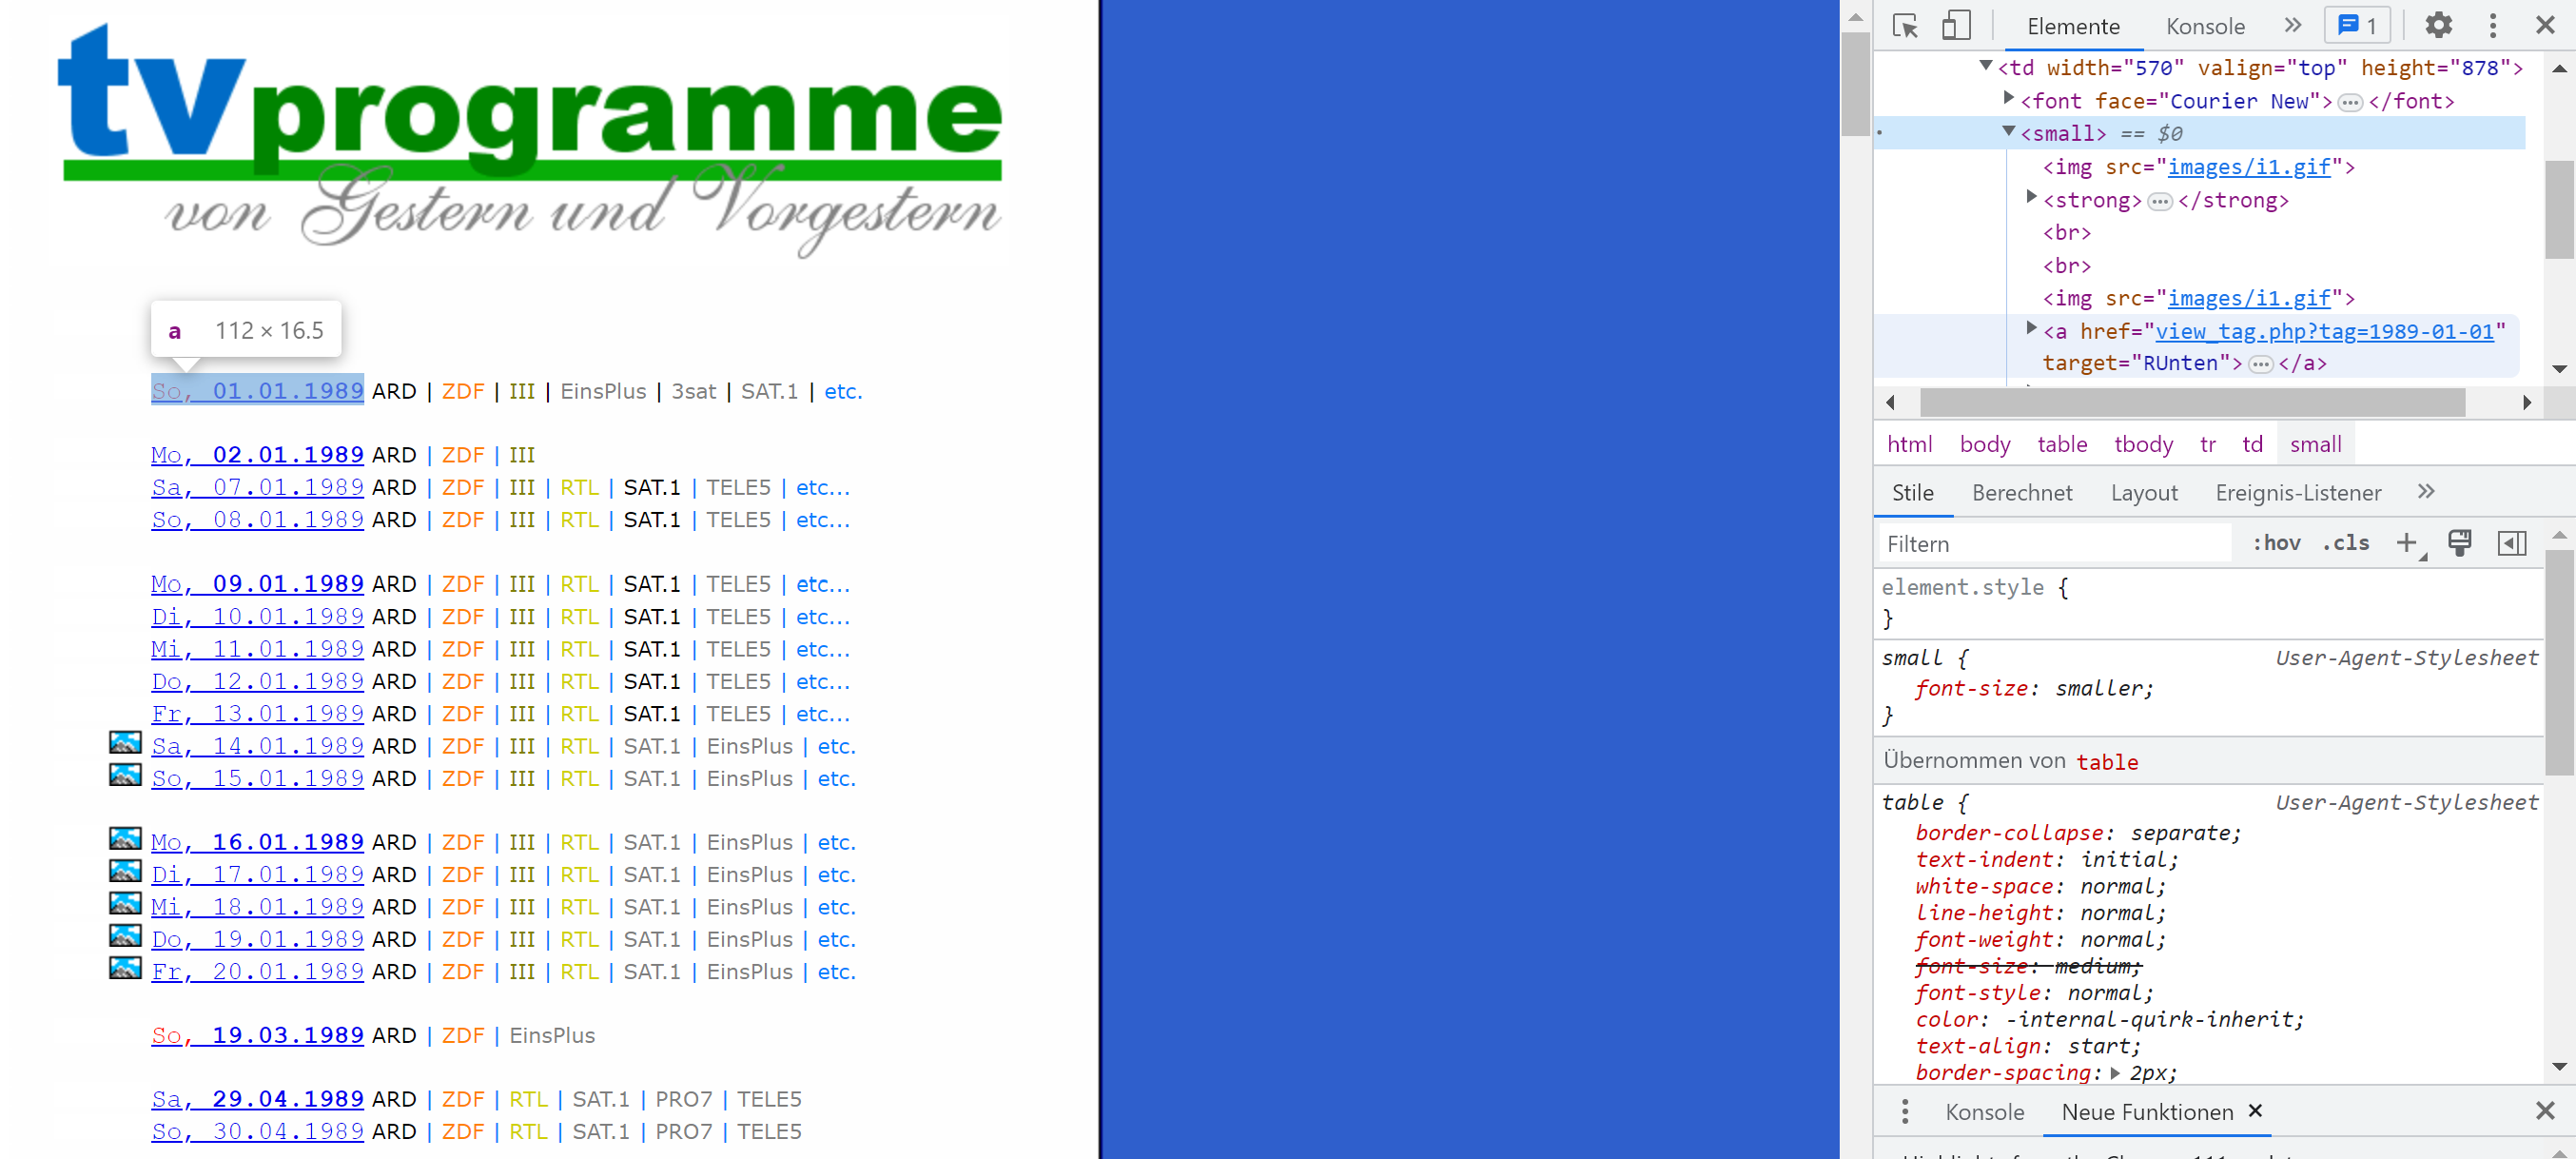

In [2]:
#http://retro-media-tv.de/tvp/show_tage.php?id=1&anf=1989-01-01&ende=1999-12-31
Image(filename='tv1.png')

In [3]:
url = "http://retro-media-tv.de/tvp/show_tage.php?id=1&anf=1989-01-01&ende=1999-12-31"
data = requests.get(url)

soup = BeautifulSoup(data.text)

First we create a function, that parses through all the links of the table for a selected Year.

In [4]:
def select_year(Y: str):
    """:parameter: Y -> String of a Year; example "1989"
    :return: List[str]; list of all links, according to the Date (month-day), in str-format
    
    #the [-10:-6] slicing is where the year is located in the <href> tag 
    # an "in" function would work as well, but slower. Since everything is uniform, Slice-indexing is used. 
    """

    prefix = "http://retro-media-tv.de/tvp/"
    As = soup.find_all("a")
    href_ = [a.get("href") for a in As]
    # print(href_)
    full_links = [prefix + sufix for sufix in href_ if sufix[-10:-6] == Y]
    return full_links

In [5]:
print(select_year("1989")[0:10], "...")

['http://retro-media-tv.de/tvp/view_tag.php?tag=1989-01-01', 'http://retro-media-tv.de/tvp/view_tag.php?tag=1989-01-02', 'http://retro-media-tv.de/tvp/view_tag.php?tag=1989-01-07', 'http://retro-media-tv.de/tvp/view_tag.php?tag=1989-01-08', 'http://retro-media-tv.de/tvp/view_tag.php?tag=1989-01-09', 'http://retro-media-tv.de/tvp/view_tag.php?tag=1989-01-10', 'http://retro-media-tv.de/tvp/view_tag.php?tag=1989-01-11', 'http://retro-media-tv.de/tvp/view_tag.php?tag=1989-01-12', 'http://retro-media-tv.de/tvp/view_tag.php?tag=1989-01-13', 'http://retro-media-tv.de/tvp/view_tag.php?tag=1989-01-14'] ...


http://retro-media-tv.de/tvp/view_tag.php?tag=1989-01-01
<br>
<br>
<br>
We take the Programms from the Year 1989 on the first of January. The Page consists of Multiple Tables according to the TV-Station, for example *RTL,Sat1,Pro7,etc.* where all the TV-shows are listed in this table with Information like: *Time, Name of the show, an extra link for further information, etc.* 
<br>
<br>
<br>

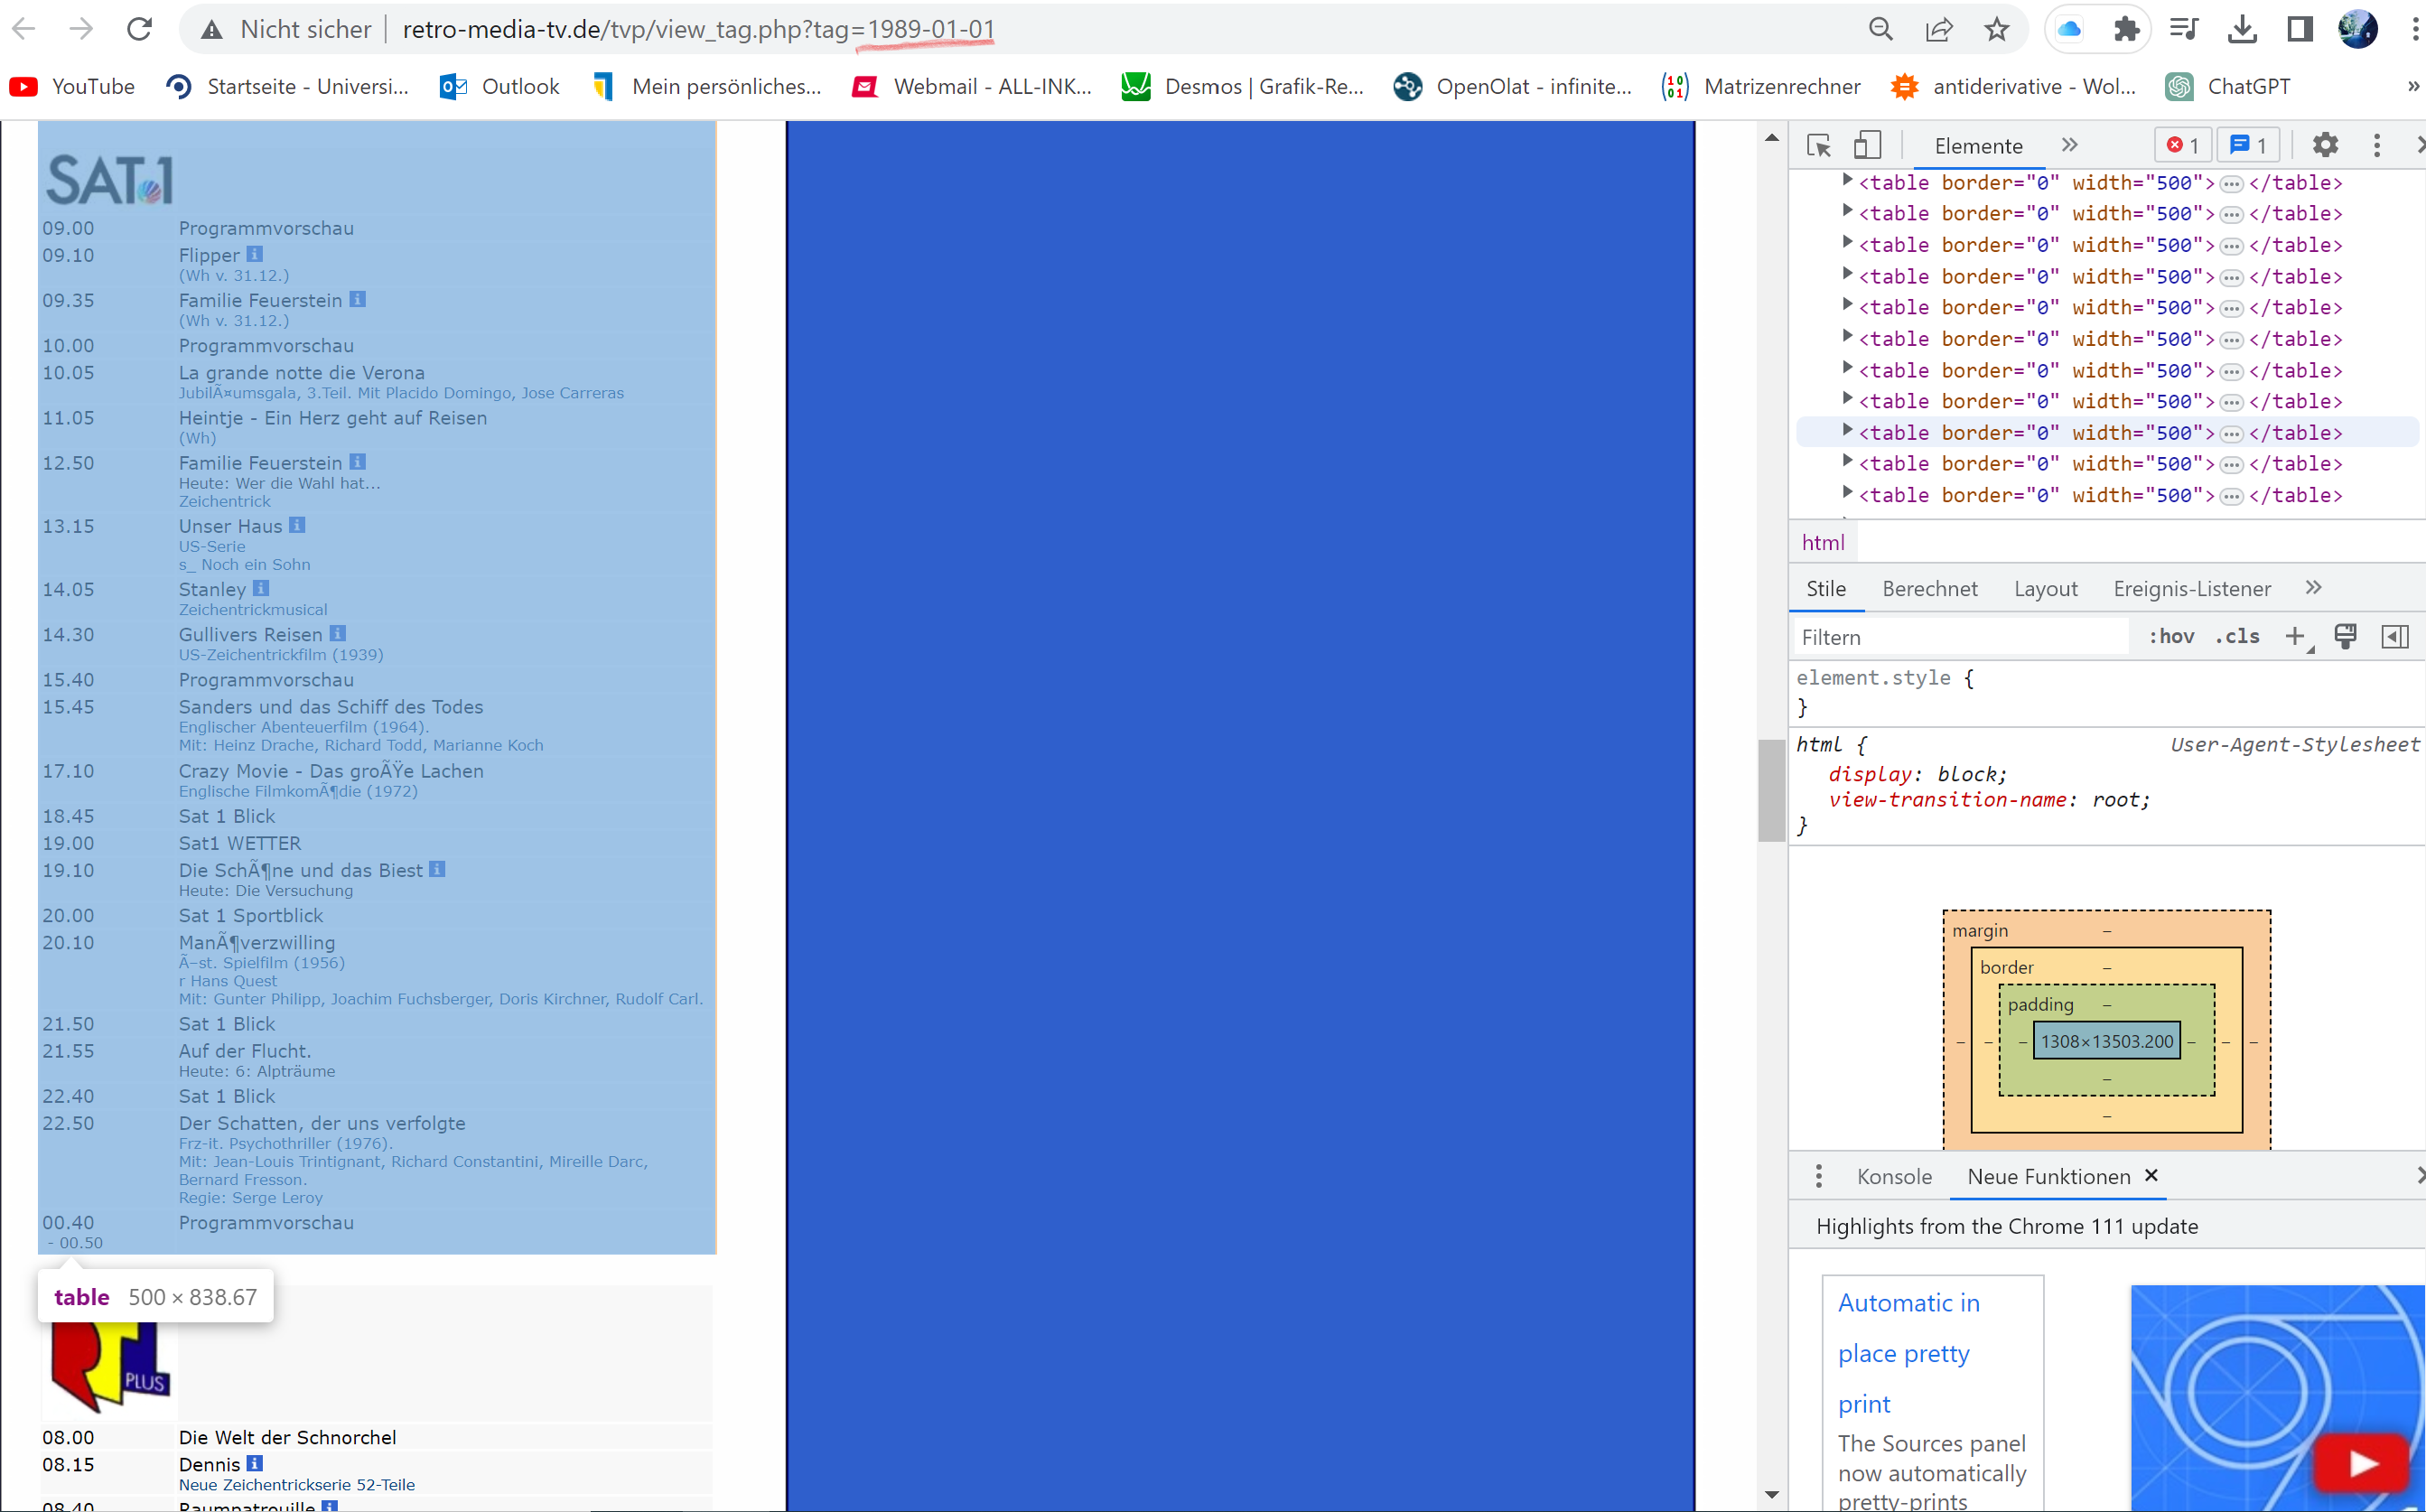

In [6]:
Image(filename='tv2.png')

If we want to find the Programm for a certain Station, we need the index of that table for later use.

In [7]:
def get_idx(th_all, station = "RTL"):
    """:parameter: th_all -> All <tables>-tags from the Page on a given Day"
    :return: The index at which the sought-after station (here RTL) is located. For example 5-th table of the Page.
    
    #The Information, on what table belongs to wich station, is stored in the img:
    <img src="images/logos/rtl-02.jpg" alt="RTL">
    """
    tables = [th.find_all("img") for th in th_all]

    for (idx, t) in enumerate(tables):
        try:
            if (t[0].get("alt") == station):
                return idx
            
        except IndexError:
            pass



As said earlier, we need to store the links (further Information of the TV-Show) in the Pandas-DataFrame we want to create. This will help us match the Information with the TV-Show while creating the Data-frame. 

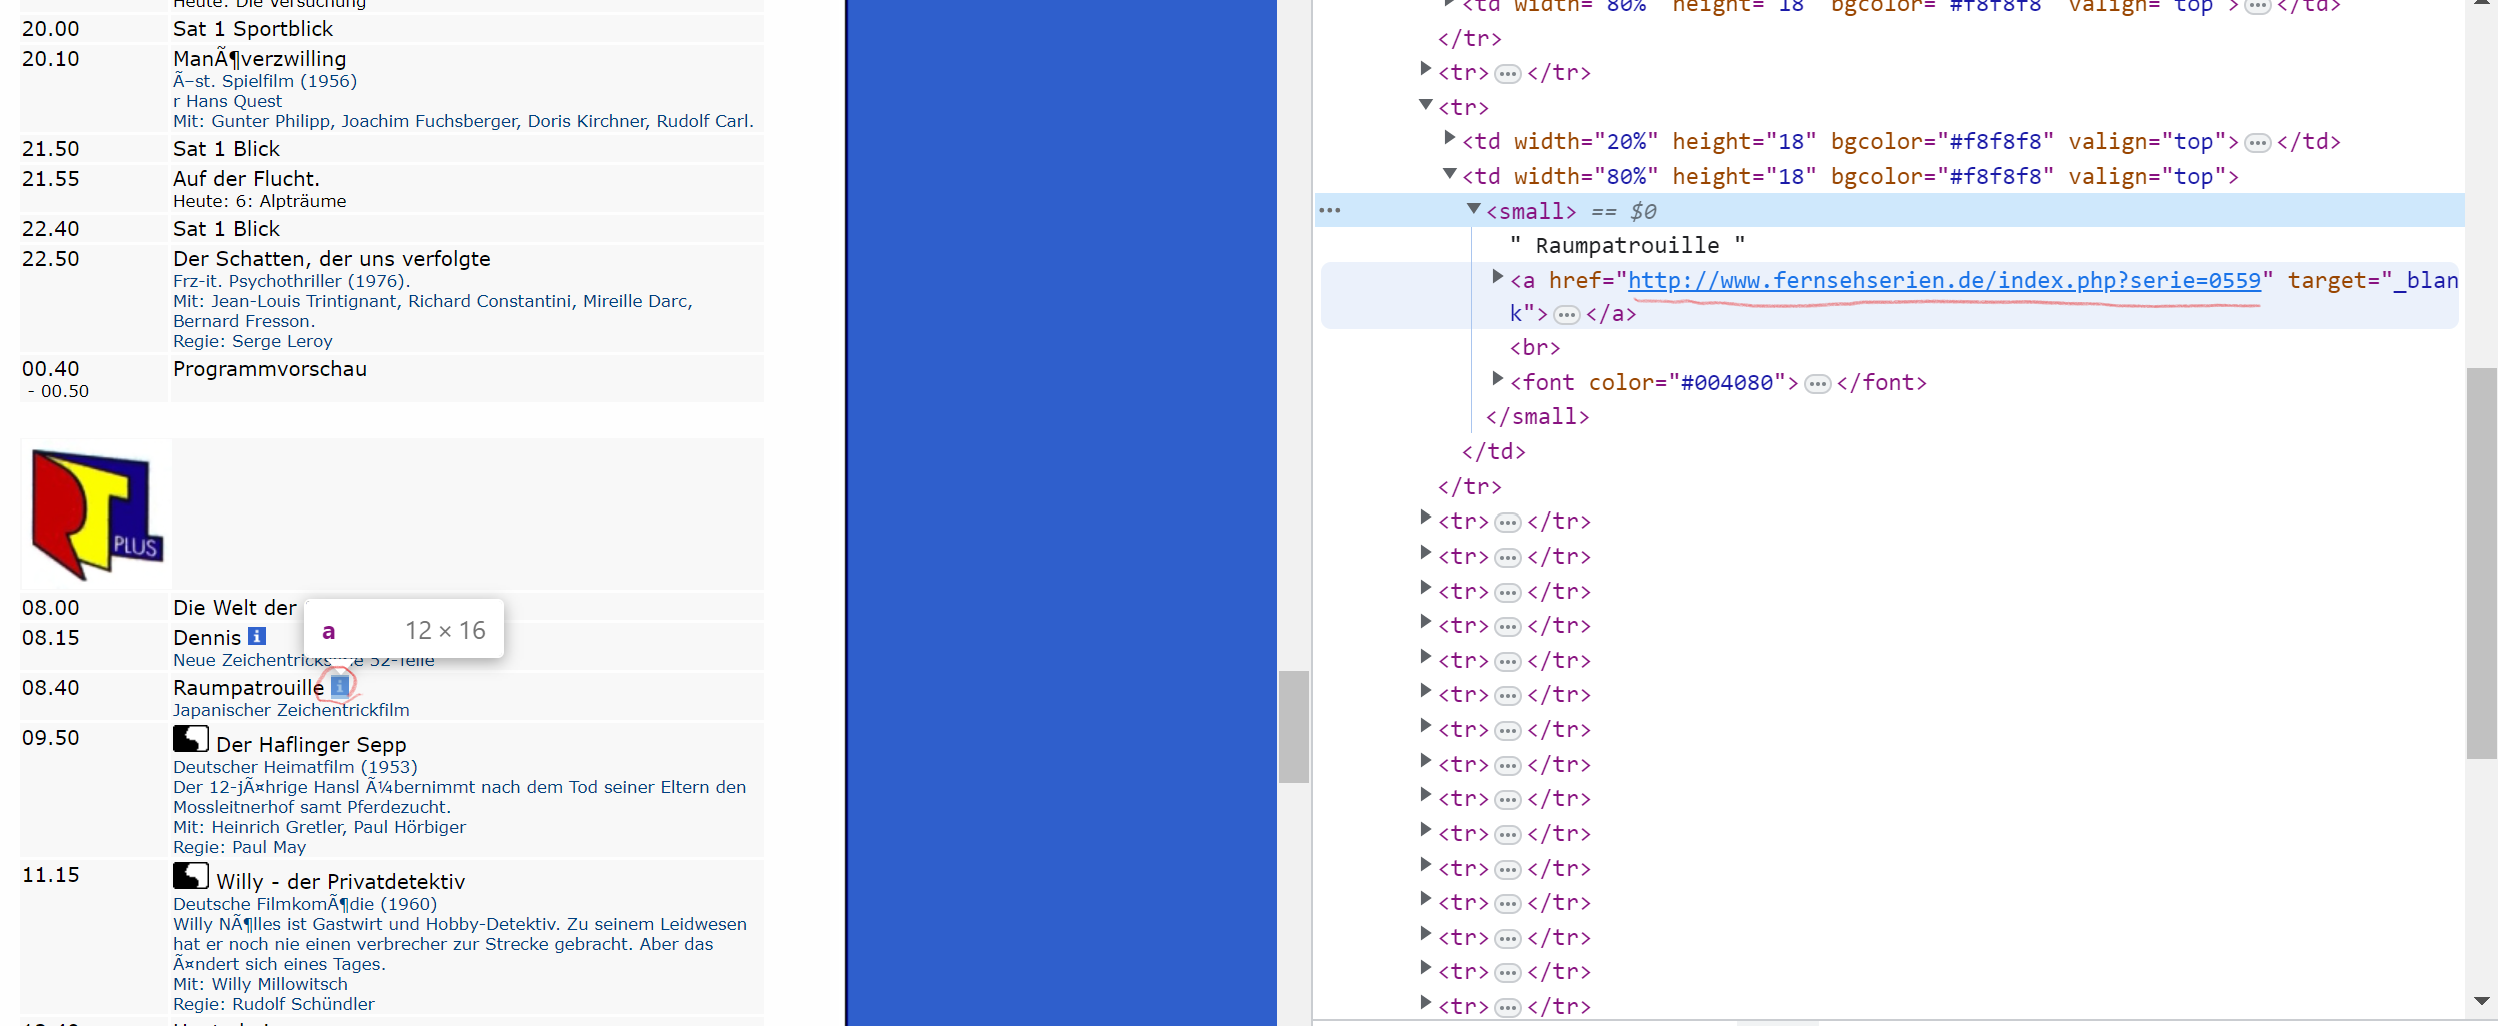

In [8]:
Image(filename='tv3.png')

In [9]:
def link_matcher(all_cells:list):
    """:parameter: all_cells -> list of all <td>-tag from a table (i.e. info of their cells.)"
    :return: dictionary with Shows as keys and links as values for the entire Table.
    
    #Table.find_all("td")
    all_cells = [<td bgcolor="#f8f8f8" height="18" valign="top" width="80%"><small> Knight Rider <br/> </small></td>, ...]
    In This example e.text would be Knight Rider, but is has no link.
    If it had one it would be accesible via e.select("a")
    """
    
    d = {e.text : e.select("a") for e in all_cells}
    res = {k.split("  ")[0]:v[0].get("href") for k,v in d.items() if v}
    return res

In [10]:
def make_df(all_cells:list, date:str, prog = "RTL"):
    """:parameter: all_cells -> All Cells from a Table <td>-tag 
                   date: date of the TV-Programms
                   prog: Programm of the TV-Programms"
                   
    :return: Pd.DataFrame with the Information of the table."""
    
    ib = [e.text for e in all_cells]
    ib = [e.split("  ") for e in ib if e != ""]  # --> [[time],[name, info],[time],[name, info],... ]
    l_m = link_matcher(all_cells)

    zeit = [l[0] for l in ib[::2]] #acces time
    sendung = [l[0] for l in ib[1::2]] #acces name 
    try:
        info = [l[1] for l in ib[1::2]] #acces info if available 
    except IndexError:
        info = None

    df = pd.DataFrame({"Program": prog, "Datum": date, "Zeit": zeit, "Serie": sendung, "Land der Produktion": None,
                       "Genre": None, "Link_info": None, "Info_text": info})
    
    #iterate through through all the rows, if the show has a link, it will be inserted in the "Link_info" column.
    for i in df.index:
        if df.Serie[i] in l_m.keys():
            df.Link_info[i] = l_m[df.Serie[i]]

    return df

In [40]:
def parse_tv(links):
    """:parameter: links -> All the Links from a year. 
    :return: list of Pd.DataFrames."""
    
    res = []
    for link in links[:]:
        date = link[-10:]

        ex = requests.get(link)
        soup = BeautifulSoup(ex.text)
        th_all = soup.select("table")

        idx = get_idx(th_all)
        if idx:
            RTL = th_all[idx]  # pick the Table
            all_cells = RTL.find_all("td") #get all cells 
            df = make_df(all_cells,date) #make DataFrame from Information 

            res.append(df)
            #print(date) #for progress-tracking

    return res

In [41]:
links = select_year("1989")
df_list = parse_tv(links)

In [42]:
fin_df = pd.concat(df_list, axis=0) #concat the list of dataframes into one

In [44]:
#export as .xlsx-file
fin_df.to_excel("beta_1989_TV.xlsx")